# ProbNumDiffEq.jl vs. various solver packages

Adapted from 
[SciMLBenchmarks.jl multi-language wrapper benchmark](https://benchmarks.sciml.ai/html/MultiLanguage/wrapper_packages.html).

In [1]:
# Imports
using LinearAlgebra, Statistics
using OrdinaryDiffEq, DiffEqDevTools, ParameterizedFunctions, Plots
using ODEInterface, ODEInterfaceDiffEq
using Sundials
using SciPyDiffEq
#using deSolveDiffEq
using MATLABDiffEq
using LSODA

using ProbNumDiffEq

┌ Info: Precompiling ProbNumDiffEq [bf3e78b0-7d74-48a5-b855-9609533b56a5]
└ @ Base loading.jl:1342


In [2]:
# Plotting theme
theme(:dao;
    linewidth=8,
    linealpha=0.7,
    markersize=5,
    markerstrokewidth=0.5,
    legend=:outerright,
)

In [3]:
# Constants used throughout this benchmark
const DENSE = false # used to decide if we smooth or not
const SAVE_EVERYSTEP = false

false

In [4]:
# Utility to benchmark the ProbNumDiffEq.jl solvers
function MyWorkPrecision(prob, abstols, reltols, alg; appxsol, kwargs...)
    println(alg)
    times, errors = [], []
    for (atol, rtol) in zip(abstols, reltols)
        sol_call() = solve(
            prob, alg; abstol=atol*1e2, reltol=rtol*1e2,
            dense=DENSE, save_everystep=SAVE_EVERYSTEP, kwargs...)
        sol = sol_call()
        tbest = 10000
        for i in 1:10
            t = @elapsed sol_call()
            tbest = min(tbest, t)
        end
        err = mean(abs.(appxsol(prob.tspan[2]) - sol.u[end]))
        push!(times, tbest)
        push!(errors, err)
        #@info "Info" atol rtol tbest err
    end
    return errors, times
end

MyWorkPrecision (generic function with 1 method)

## 1: Lotka-Volterra (non-stiff)

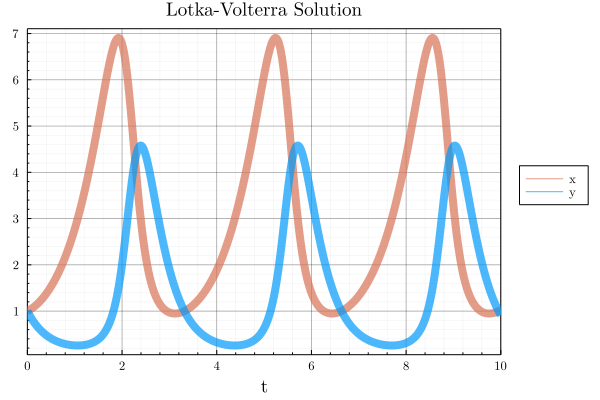

In [5]:
# Problem definition and reference solution
lv = @ode_def LotkaVolterra begin
  dx = a*x - b*x*y
  dy = -c*y + d*x*y
end a b c d
p = [1.5,1,3,1]
tspan = (0.0,10.0)
u0 = [1.0,1.0]
prob = ODEProblem(lv,u0,tspan,p)
sol = solve(remake(prob, u0=big.(prob.u0), tspan=big.(prob.tspan)),
            Vern9(), abstol=1/10^20, reltol=1/10^20)
test_sol = TestSolution(sol)

plot(sol, title="Lotka-Volterra Solution")

In [6]:
# Non-probabilistic solvers:
setups = [Dict(:alg=>Tsit5())
          Dict(:alg=>Vern9())
          Dict(:alg=>RadauIIA5())
          Dict(:alg=>ODEInterfaceDiffEq.dopri5())
          Dict(:alg=>ODEInterfaceDiffEq.rodas())
          Dict(:alg=>MATLABDiffEq.ode45())
          Dict(:alg=>MATLABDiffEq.ode113())
          Dict(:alg=>SciPyDiffEq.RK45())
          Dict(:alg=>SciPyDiffEq.LSODA())
          Dict(:alg=>Sundials.CVODE_Adams())
          Dict(:alg=>LSODA.lsoda())
  ]

names = [
  "Julia: Tsit5"
  "Julia: Vern9"
  "Julia: RadauIIA5"
  "Hairer: dopri5"
  "Hairer: rodas"
  "MATLAB: ode45"
  "MATLAB: ode113"
  "SciPy: RK45"
  "SciPy: LSODA"
  "Sundials: Adams"
  "liblsoda: LSODA"
  ]
solver_colors = [1 1 1 2 2 3 3 4 4 5 6];

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)

wp = WorkPrecisionSet(prob,abstols,reltols,setups;                  
    names=names,
    print_names=true,
    appxsol=test_sol,
    dense=DENSE,
    save_everystep=SAVE_EVERYSTEP,
    numruns=10,
    maxiters=Int(1e5),
    timeseries_errors=false,
    verbose=false
)

Julia: Tsit5
Julia: Vern9
Julia: RadauIIA5
Hairer: dopri5
Hairer: rodas
MATLAB: ode45
MATLAB: ode113
SciPy: RK45
SciPy: LSODA
Sundials: Adams
liblsoda: LSODA


WorkPrecisionSet of 11 wps


In [7]:
# ProbNumDiffEq.jl solvers:
pn_algs = [
    EK0(order=5, smooth=DENSE),
    EK1(order=5, smooth=DENSE),
]

pn_names = [
    "PNDE.jl: EK0(5)",
    "PNDE.jl: EK1(5)",
]

pn_wps = [
    MyWorkPrecision(prob, abstols, reltols, alg; appxsol=test_sol) 
    for alg in pn_algs
];

EK0{TaylorModeInit}(:ibm, 5, :dynamic, false, TaylorModeInit())
EK1{TaylorModeInit}(:ibm, 5, :dynamic, false, TaylorModeInit())


#### Results

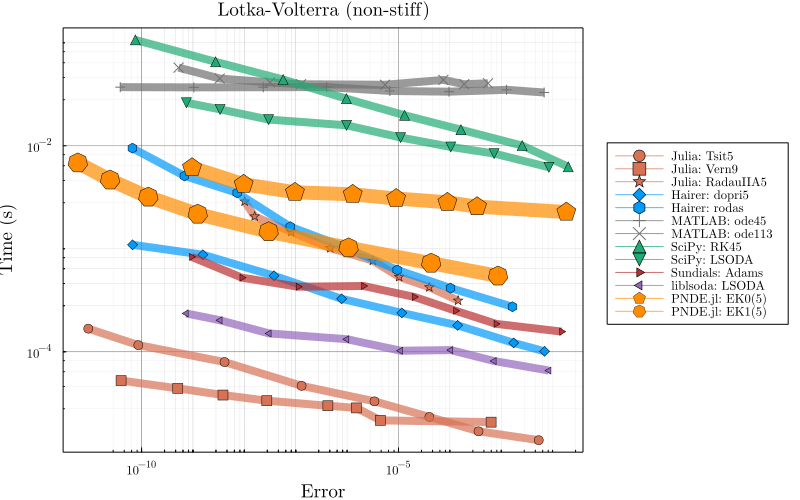

In [8]:
wp_plot = plot(wp, title="Lotka-Volterra (non-stiff)", size=(800,500), color=solver_colors, linewidth=8)
for (n, w) in zip(pn_names, pn_wps)
    plot!(wp_plot, w..., label=n, color=:darkorange, marker=:auto, markersize=10, linewidth=14)
end
wp_plot

## 2: Van-der-Pol (stiff)

In [9]:
# Problem definition and reference solution
vdp = @ode_def begin
  dy = μ*((1-x^2)*y - x)
  dx = 1*y
end μ
prob = ODEProblem(vdp, [0.0, 2.0], (0.0, 6.3), 1e6)
sol = solve(remake(prob, u0=big.(prob.u0), tspan=big.(prob.tspan)),
    RadauIIA5(), abstol=1/10^25, reltol=1/10^25)
test_sol = TestSolution(sol)

plot(sol, title="Van-der-Pol Solution", ylim=[-5, 5], legend=false)

In [13]:
# Non-probabilistic solvers
abstols = 1.0 ./ 10.0 .^ (7:14)
reltols = 1.0 ./ 10.0 .^ (4:11)

setups = [Dict(:alg=>RadauIIA5())
          Dict(:alg=>Rodas5())
          Dict(:alg=>QNDF())
          Dict(:alg=>ODEInterfaceDiffEq.rodas())
          Dict(:alg=>ODEInterfaceDiffEq.radau())
          #Dict(:alg=>MATLABDiffEq.ode23s()) # Not able to solve VdP!
          Dict(:alg=>MATLABDiffEq.ode15s())
          Dict(:alg=>SciPyDiffEq.LSODA())
          Dict(:alg=>SciPyDiffEq.BDF())
          Dict(:alg=>Sundials.CVODE_BDF())
          Dict(:alg=>LSODA.lsoda())
          ]

names = [
  "Julia: RadauIIA5"
  "Julia: Rodas5"
  "Julia: QNDF"
  "Hairer: rodas"
  "Hairer: radau"
  #"MATLAB: ode23s"
  "MATLAB: ode15s"
  "SciPy: LSODA"
  "SciPy: BDF"
  "Sundials: CVODE"
  "liblsoda: LSODA"
  ]

solver_colors = [1 1 1 2 2 3 4 4 5 6];

wp = WorkPrecisionSet(prob, abstols, reltols, setups;
    names=names,
    print_names=true,
    appxsol=test_sol,
    dense=DENSE,
    save_everystep=SAVE_EVERYSTEP,
    numruns=10,
    maxiters=Int(1e6),
    timeseries_errors=false,
    verbose=false)

Julia: RadauIIA5
Julia: Rodas5
Julia: QNDF
Hairer: rodas
Hairer: radau
MATLAB: ode15s
SciPy: LSODA
SciPy: BDF
Sundials: CVODE
liblsoda: LSODA


WorkPrecisionSet of 10 wps


In [19]:
# ProbNumDiffEq.jl solvers:
pn_algs = [
    EK1(order=3, smooth=DENSE),
    EK1(order=5, smooth=DENSE),
    EK1(order=7, smooth=DENSE),
]

pn_names = [
    "PNDE.jl: EK1(3)",
    "PNDE.jl: EK1(5)",
    "PNDE.jl: EK1(7)",
]

pn_wps = [
    MyWorkPrecision(prob, abstols, reltols, alg; appxsol=test_sol, maxiters=1e6) 
    for alg in pn_algs
];

EK1{TaylorModeInit}(:ibm, 3, :dynamic, false, TaylorModeInit())
EK1{TaylorModeInit}(:ibm, 5, :dynamic, false, TaylorModeInit())
EK1{TaylorModeInit}(:ibm, 7, :dynamic, false, TaylorModeInit())


#### Results

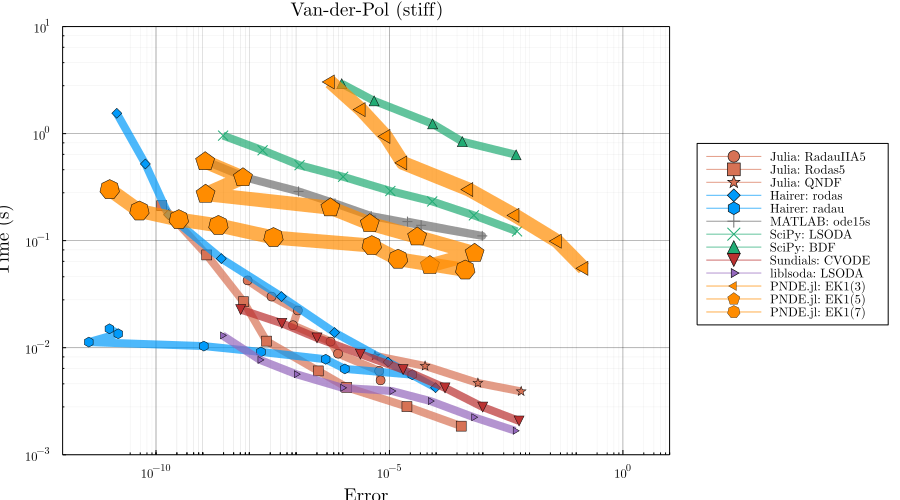

┌ Warning: Invalid negative or zero value 0.0 found at series index 5 for log10 based xscale
└ @ Plots /home/nath/.julia/packages/Plots/HcxwM/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 6 for log10 based xscale
└ @ Plots /home/nath/.julia/packages/Plots/HcxwM/src/utils.jl:95


In [20]:
wp_plot = plot(wp, title="Van-der-Pol (stiff)", size=(900,500), color=solver_colors, linewidth=8,
xlims=(1e-12, 1e1), ylims=(1e-3, 1e1)
)
for (n, w) in zip(pn_names, pn_wps)
    plot!(wp_plot, w..., label=n, color=:darkorange, marker=:auto, markersize=10, linewidth=14)
end
wp_plot